In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree

In [2]:
anatree = Anatree("/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/anatree_hd_AV_2dot5_random_sum_300k_new.root", entry_start=0, entry_stop=1000, load_data=False)
anatree.tree:uproot.TTree
anatree.read_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/parquet_new',batches=-1, concat=False)#, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)

Reading nu files... 30/30
Reading geant files... 30/30
Reading reco_tracks files... 30/30
Reading reco_showers files... 30/30
Reading pfp files... 30/30


In [3]:
nu = anatree.nu
geant = anatree.geant
shw = anatree.reco_showers
tracks = anatree.reco_tracks
showers = anatree.reco_showers
merged:pl.DataFrame
merged = 0
for i,n in enumerate(nu):
    df = anatree.get_full_reco_tracks(tracks[i], geant[i], nu[i])
    df = df.collect()
    if i == 0:
        merged = df
    else:
        merged = pl.concat([merged,df])

In [4]:
geant_nu:pl.DataFrame
geant_nu = 0
for i,n in enumerate(nu):
    dfg = geant[i]#.head(1000000)
    dfnu = n.filter((pl.col('ccnc_truth')==0) & (pl.col('nuPDG_truth').abs()==14))
    dfg = dfg.filter((pl.col('Mother_geant')==0) & (pl.col('pdg_geant').abs() == 13))
    gcc = (
        dfg.join(dfnu, left_on=['subrun','event'], right_on=['subrun', 'event'], how='inner')
    ).collect()
    if i == 0:
      geant_nu = gcc  
    else:
        geant_nu = pl.concat([geant_nu,gcc])
        # if i == 1:
        #    break

In [5]:
df:pl.DataFrame
df = merged
pfp = merge_same_df(anatree.pfp)
nu = merge_same_df(anatree.nu)

In [6]:
df = df.filter(
    pl.col('has_valid_pfp') == 1
)
df = df.with_columns(
    track_angle_diff = ((pl.col('trkstartdcosx_pandoraTrack')*pl.col('Px_geant') +
                         pl.col('trkstartdcosy_pandoraTrack')*pl.col('Py_geant') +
                         pl.col('trkstartdcosz_pandoraTrack')*pl.col('Pz_geant'))/pl.col('P_geant')).arccos()
)


In [7]:

def create_intervals():
    global Ebins
    intervals = []
    for i, e in enumerate(Ebins[:-1]):
        intervals.append(f'[{e} - {Ebins[i+1]}) GeV')
    return intervals
def plot_by_energy(bins, df:pl.DataFrame, variables, labels, fig=None, columns = 3, show_entries=False, **kwargs):

    global Ebins
    if 'figsize' in kwargs:
        figsize=kwargs.pop('figsize')
    else:
        figsize=(14,10)

    nplots = len(Ebins) - 1
    rows = nplots//columns
    last_empty= False
    if nplots%columns != 0:
        last_empty = True
        rows+=1

    qc = [] 
    intervals = []
    entries = []
    for i, e in enumerate(Ebins[:-1]):
        qt = df.filter(
            (pl.col('enu_truth') >= e) & (pl.col('enu_truth') < Ebins[i+1])
        ).with_columns(
            counts = pl.col('enu_truth').count()
        )
        qc.append(qt)
        entries.append(qt.head(1)['counts'].to_numpy())
        intervals.append(f'[{e} - {Ebins[i+1]}) GeV')
        
    axes=0 
    if fig is None:
        fig, axes = plt.subplots(rows,columns,figsize=figsize)
    else:
        axes = fig.get_axes()

    try:
        axes = axes.flatten()
    except:
        axes = axes

    vbin_centers = [0 for _ in axes]
    vbin_heights = [0 for _ in axes]
    for i, (inter,ax) in enumerate(zip(intervals,axes)):
        ax:plt.Axes
        for var,label in zip(variables,labels):
            if show_entries: label = label + f': {entries[i]} events'
            bin_heights, bin_borders, _ = ax.hist(qc[i][var], bins=bins, histtype='step', label=label, density=True);
            bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
            vbin_centers[i] = bin_centers
            vbin_heights[i] = bin_heights
            ax.set_xlabel(r'$\theta$(degrees) $\equiv$ $\cos^{-1} [\vec{p}_{final} \cdot \vec{p}_{\nu_\mu}/(|\vec{p}_{final}| |\vec{p}_{\nu_\mu}|)]$', fontsize=20)
            ax.tick_params(labelsize=18)
            ax.legend(frameon=True, title=intervals[i])
    return fig, vbin_centers, vbin_heights


def show_credibility(axes, x, y, idx=1, hist_idx = 0, cred = 0.68):
    global Ebins
    intervals = create_intervals()

    hist_cred =  get1Dcred(y[idx],cred)
    min_cred = min(hist_cred)
    max_cred = max(hist_cred)
    mode_cred = hist_cred[0]

    ax:plt.Axes
    ax = axes[idx]
    c = ax.patches[hist_idx].get_facecolor()[:-1]
    ax.axvline(x[idx][mode_cred], c='red', linestyle='--', label=fr'MPV: {x[idx][mode_cred]:0.2f}$^\circ$')
    ax.axvline(x[idx][min_cred], c=c, linestyle='--')
    ax.axvline(x[idx][max_cred], c=c, linestyle='--', label=rf'$1\sigma$ (max: {x[idx][max_cred]:0.2f}$^\circ$, min: {x[idx][min_cred]:0.2f}$^\circ$)')
    ax.legend(frameon=True, title=intervals[idx])

def get_angle(str_g, str_nu, geant_type='geant'):
    variables = ['x','y','z']
    mom_geant = [str_g + v + '_' + geant_type for v in variables]
    mom_nu = [str_nu+v + '_truth'for v in variables]
    r = pl.col(mom_geant[0])*pl.col(mom_nu[0])
    for mg, mn in zip(mom_geant[1:], mom_nu[1:]):
        r += pl.col(mg)*pl.col(mn)

    # return r
    return (r/pl.col(str_g+'_'+geant_type).abs()).arccos()*180/np.pi

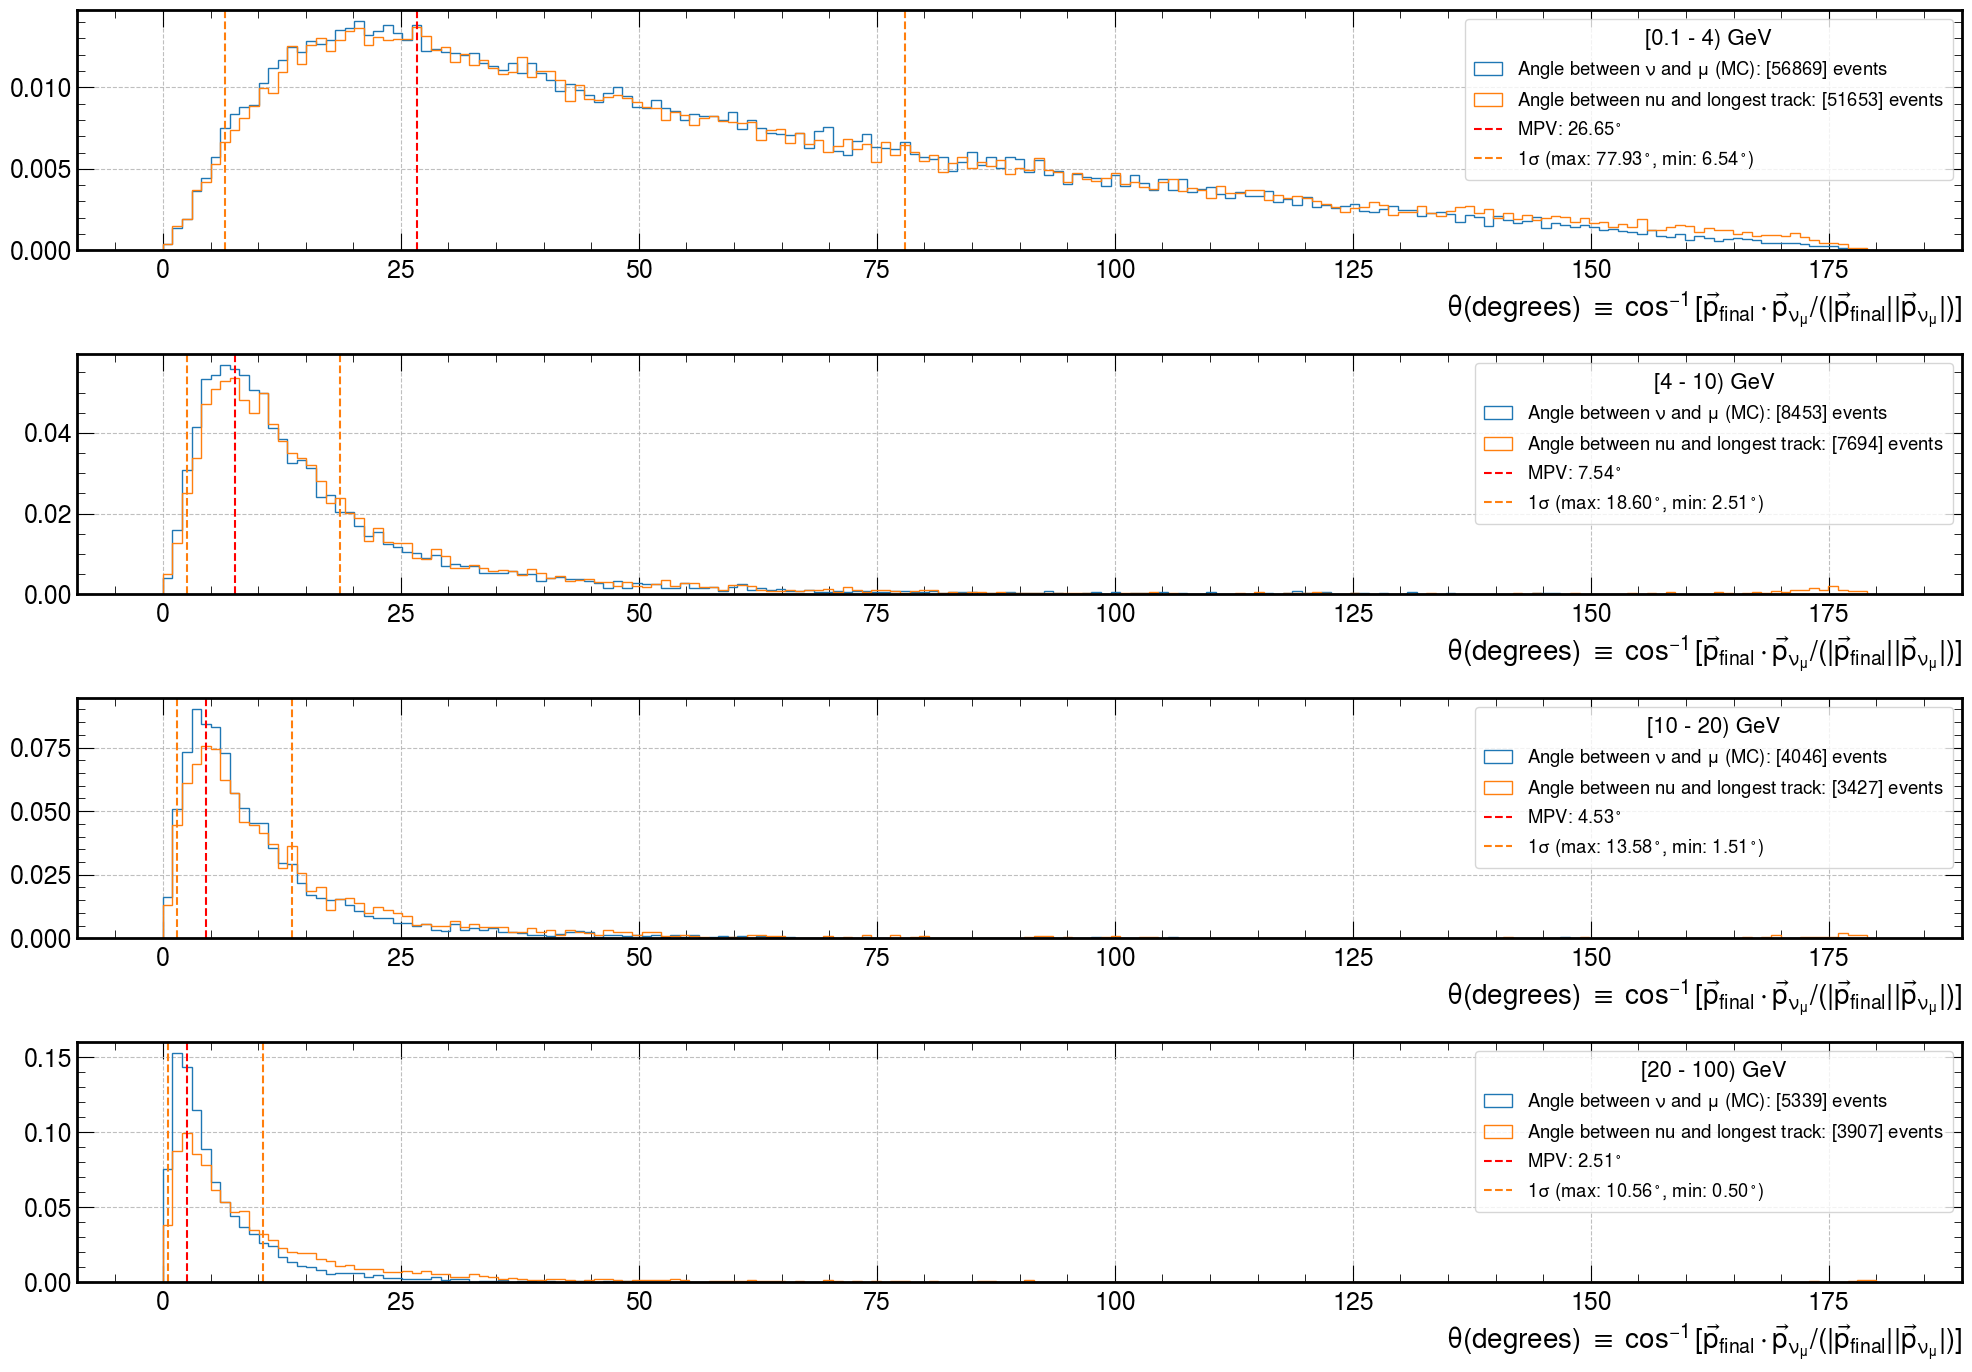

In [292]:
btrack = df.filter(
        (pl.col('ccnc_truth').abs()==0) & (pl.col('nuPDG_truth').abs()==14)
    ).filter(
        # True
        (pl.col('pdg_geant').abs()==13) & (pl.col('Mother_geant')==0)
    ).sort('trklen_pandoraTrack',descending=True).groupby(selection_events()).agg(
        pl.col('trklen_pandoraTrack').first().alias('len'),
        nux = pl.col('nu_dcosx_truth').first(),
        nuy = pl.col('nu_dcosy_truth').first(),
        nuz = pl.col('nu_dcosz_truth').first(),
        enu_truth = pl.col('enu_truth').first(),
        tx = pl.col('trkstartdcosx_pandoraTrack').first(),
        ty = pl.col('trkstartdcosy_pandoraTrack').first(),
        tz = pl.col('trkstartdcosz_pandoraTrack').first(),
    ).with_columns(
        diff = (pl.col('nux')*pl.col('tx') + 
        pl.col('nuy')*pl.col('ty') +
        pl.col('nuz')*pl.col('tz')).arccos()*180/np.pi,
    )

q = (
    geant_nu.filter(
        # True
        (pl.col('ccnc_truth').abs()==0) & (pl.col('nuPDG_truth').abs()==14)
    ).filter(
        (pl.col('pdg_geant').abs()==13) & (pl.col('Mother_geant')==0)
    ).with_columns(
        # angle_diff = get_angle('StartP','nu_dcos',geant_type='drifted_geant'),
        # pl.col('enu_truth'),
        angle_diff = get_angle('P','nu_dcos'),
    # ).groupby(selection_events()).agg(
    #     pl.col('enu_truth').first(),
    #     angle_diff = get_angle('P','nu_dcos').first(),
    )
)

bins = np.linspace(0,180,180)
Ebins = [0.1,4,10,20,100]
fig , x0, y0 = plot_by_energy(bins=bins,df=q,variables=['angle_diff'],labels=[r'Angle between $\nu$ and $\mu$ (MC)'], columns=1, show_entries=True, figsize=(20,14))
fig, x, y = plot_by_energy(bins=bins,df=btrack,variables=['diff'],labels=[r'Angle between $nu$ and longest track'], fig=fig, columns=2, show_entries=True, figsize=(20,14))
axes = fig.axes
show_credibility(axes,x,y, idx=0, hist_idx = 1)
show_credibility(axes,x,y, idx=1, hist_idx = 1)
show_credibility(axes,x,y, idx=2, hist_idx = 1)
show_credibility(axes,x,y, idx=3, hist_idx = 1)

In [9]:
btrack = df.filter(
        (pl.col('ccnc_truth').abs()==0) & (pl.col('nuPDG_truth').abs()==14)
    ).filter(
        True
        # (pl.col('pdg_geant').abs()==13) & (pl.col('Mother_geant')==0)
    ).sort('trklen_pandoraTrack',descending=True).groupby(selection_events()).agg(

        pl.col('trklen_pandoraTrack').first().alias('len'),
        nux = pl.col('nu_dcosx_truth').first(),
        nuy = pl.col('nu_dcosy_truth').first(),
        nuz = pl.col('nu_dcosz_truth').first(),
        enu_truth = pl.col('enu_truth').first(),
        tx = pl.col('trkstartdcosx_pandoraTrack').first(),
        ty = pl.col('trkstartdcosy_pandoraTrack').first(),
        tz = pl.col('trkstartdcosz_pandoraTrack').first(),
    ).with_columns(
        diff = (pl.col('nux')*pl.col('tx') + 
        pl.col('nuy')*pl.col('ty') +
        pl.col('nuz')*pl.col('tz')).arccos()*180/np.pi,
    )

q = (
    geant_nu.filter(
        (pl.col('ccnc_truth').abs()==0) & (pl.col('nuPDG_truth').abs()==14)
    ).filter(
        (pl.col('pdg_geant').abs()==13) & (pl.col('Mother_geant')==0)
    # ).with_columns(
    #     # angle_diff = get_angle('StartP','nu_dcos',geant_type='drifted_geant'),
    #     # pl.col('enu_truth'),
    #     angle_diff = get_angle('P','nu_dcos'),
    # ).groupby(selection_events()).agg(
    #     pl.col('pdg_geant'),
    #     pl.col('enu_truth').first(),
    #     angle_diff = get_angle('P','nu_dcos').first(),
    ).sort(selection_events())
)
q.filter(
    True
    # (pl.col('pdg_geant').abs()==13) & (pl.col('Mother_geant')==0)
).groupby(selection_events()).agg(
    pl.all().first()
)
print(len(btrack))
print(len(q))

73107
74707


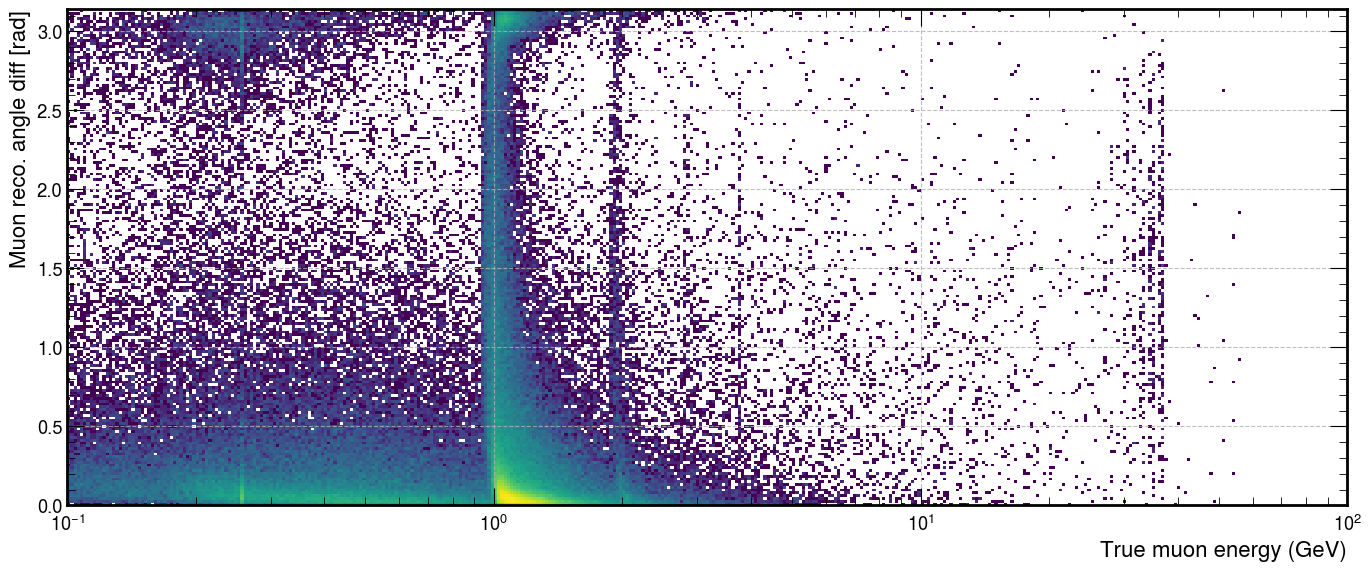

In [10]:
t = df.fill_nan(0)
# t = df.filter(pl.col('pdg_geant').abs()==13).filter(pl.col('Mother_geant')==0)
t = t.filter(pl.col('Mother_geant')!=0)
binsx = np.linspace(0,3000,200)
binsx = np.logspace(-1,2,400)
binsy = np.linspace(0,np.pi,180)
plt.hist2d(t['Eng_geant'], t['track_angle_diff'], bins=[binsx,binsy], norm=LogNorm());
plt.xscale('log')
plt.ylabel('Muon reco. angle diff [rad]')
plt.xlabel('True muon energy (GeV)')
plt.show()

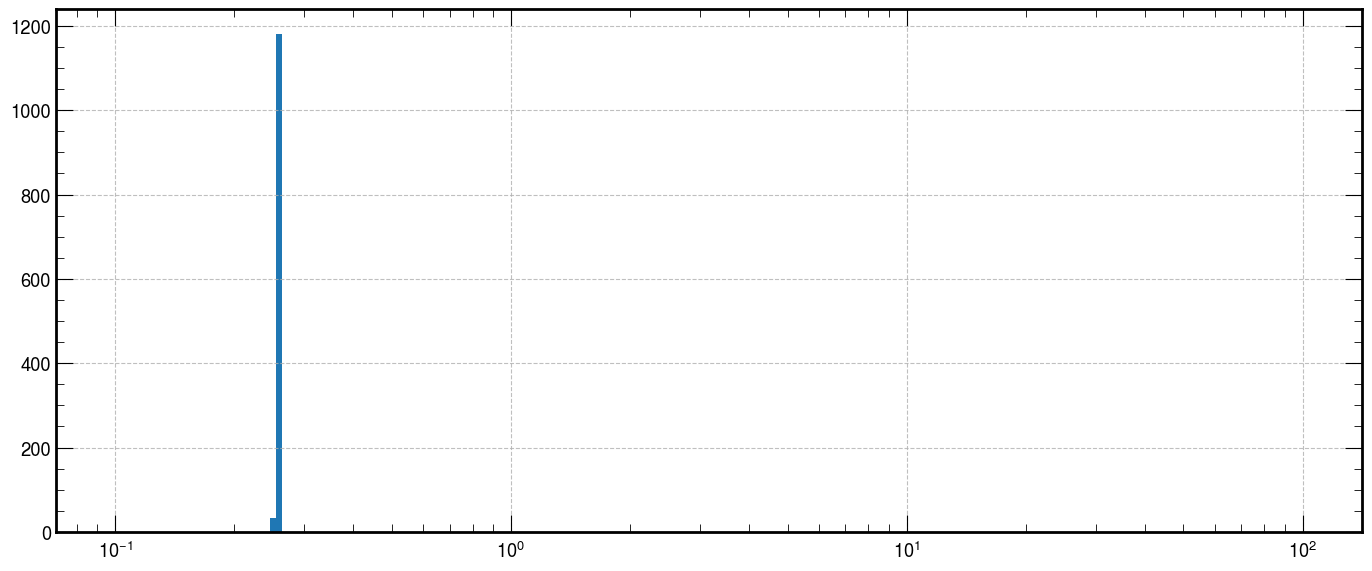

In [231]:
test_en_bias = df.filter(

    ( pl.col('pdg_geant').abs()==13 ) & (pl.col('Mother_geant')!=0)
).filter(
    ( pl.col('P_geant')>0.229 ) & (pl.col('P_geant')< 0.24)
)

a, b, c = plt.hist(
    test_en_bias['Eng_geant'],
    bins = np.logspace(-1,2,200),
    );
plt.xscale('log')

test_en_bias = test_en_bias.groupby(selection_events(['Mother_geant', 'trkg4id_pandoraTrack', 'pdg_geant', 'Eng_geant'])).agg()
test = 0
for i, g in enumerate(geant):
    temp = g.join(test_en_bias.lazy(), left_on=selection_events(['TrackId_geant']), right_on=selection_events(['Mother_geant']), how='inner')
    temp = temp.collect()
    if i == 0:
        test =  temp
    else:
        
        test = pl.concat([test,temp], rechunk=False)

test_en_bias = test_en_bias.sort(selection_events()).select(selection_events(['trkg4id_pandoraTrack']))

In [310]:
# test_en_bias
from anytree import Node, RenderTree
nodes:Node

def make_tree(df:pl.DataFrame, subrun, event):
    nodes = {}
    def add_nodes(nodes, parent, child):
        if parent not in nodes:
            nodes[parent] = Node(parent)  
        if child not in nodes:
            nodes[child] = Node(child)
        nodes[child].parent = nodes[parent]
    df = df.filter(get_event(subrun=subrun,event=event))
    mother_and_selfid = df.select(['Mother_geant', 'TrackId_geant']).collect().to_numpy()
    for parent, child in zip(mother_and_selfid[:,0], mother_and_selfid[:,1]):
        add_nodes(nodes, parent, child)
        # print(nodes)
    return nodes

def print_tree(nu:pl.DataFrame, geant:pl.DataFrame, nodes:Node, subrun:int, event:int, maxlevel=2, particle_id = 0, only_ancestor=False, **kwargs):
    rendered = RenderTree(nodes[particle_id], maxlevel=maxlevel)
    if only_ancestor:
        try:
            # particle_id = nodes[particle_id].ancestors[1].name
            nodes = nodes[particle_id].ancestors + (nodes[particle_id],) #add self as tuple 
            particle_id = 0
            rendered = []
            pre=''
            gap=''
            for i, node in enumerate(nodes):
                rendered.append([gap+pre,'none',node])
                gap=gap+'   '
                pre='└── '



        except IndexError:
            pass

    nu = nu.filter((get_event(subrun,event)))
    geant = geant.filter((get_event(subrun,event)))
    
    for pre, _, node in rendered:
        print(f"{pre}{node.name}:", end= " ")
        if node.name == 0:
            nupdg = particle.Particle.from_pdgid(nu.select('nuPDG_truth').item()).name
            print(fr"{nupdg} E = {nu.select('enu_truth').item():.2f} GeV", end=" ")
            print("")
        else:
            geant_info = geant.filter(pl.col('TrackId_geant')==node.name).select(
                pl.col('pdg_geant'),
                pl.col(list(kwargs.values()))
            ).collect()
            ppdg = geant_info.select('pdg_geant').item()
            # for key, val in kwargs.items():
                # print(f"{key}: {self.pdgs[node.name][1]}", end=" ")
            print(f"{particle.Particle.from_pdgid(ppdg)}", end=" ")
            for key, val in kwargs.items():
                extra_info = geant_info.select(pl.col(val)).item()
                print(f"{key} = {extra_info:.2f};", end=" ")
            print("")




subruns=[57]
events=[17]
ids=[0]
nodes = {}
the_file = 0
# subruns = test_en_bias.get_column('subrun').to_list()[:10]
# events = test_en_bias.get_column('event').to_list()
# ids = test_en_bias.get_column('trkg4id_pandoraTrack').to_list()
for subrun, event, id in zip(subruns, events, ids):
    for i, g in enumerate( anatree.geant ):
        nodes = make_tree(g, subrun, event)
        if len(nodes) > 0:
            the_file = i
            break

    print_tree(nu, geant[the_file], nodes, particle_id=id, subrun=subrun, event=event, only_ancestor=False, maxlevel=2, P='P_geant')
# nodes.ite


0: nu(mu) E = 0.40 GeV 
├── 1: mu- P = 0.14; 
├── 2: p P = 0.19; 
├── 3: p P = 0.16; 
├── 4: n P = 0.13; 
├── 5: n P = 0.10; 
├── 6: p P = 0.10; 
├── 7: p P = 0.13; 
├── 8: n P = 0.17; 
├── 9: n P = 0.17; 
├── 10: p P = 0.23; 
├── 11: p P = 0.14; 
├── 12: n P = 0.05; 
├── 13: n P = 0.12; 
├── 14: p P = 0.06; 
├── 15: p P = 0.16; 
├── 16: n P = 0.21; 
├── 17: n P = 0.11; 
├── 18: p P = 0.18; 
├── 19: n P = 0.07; 
├── 20: n P = 0.17; 
└── 21: n P = 0.14; 


<LazyFrame [71 cols, {"subrun": Int32 … "processname_geant": Utf8}] at 0x7FBB9E4F74F0>

In [326]:

test = geant[the_file].collect()
test.filter(get_event(57,17)).filter(pl.col("Mother_geant")==0).select(
    pl.col('pdg_geant').apply(lambda x: particle.Particle.from_pdgid(x)),
    pl.col('Eng_geant') - pl.col('Mass_geant')
)


pdg_geant,Eng_geant
object,f32
mu-,0.069683
p,0.018443
p,0.013486
n,0.009214
n,0.004889
p,0.005797
p,0.009521
n,0.015494
n,0.015219


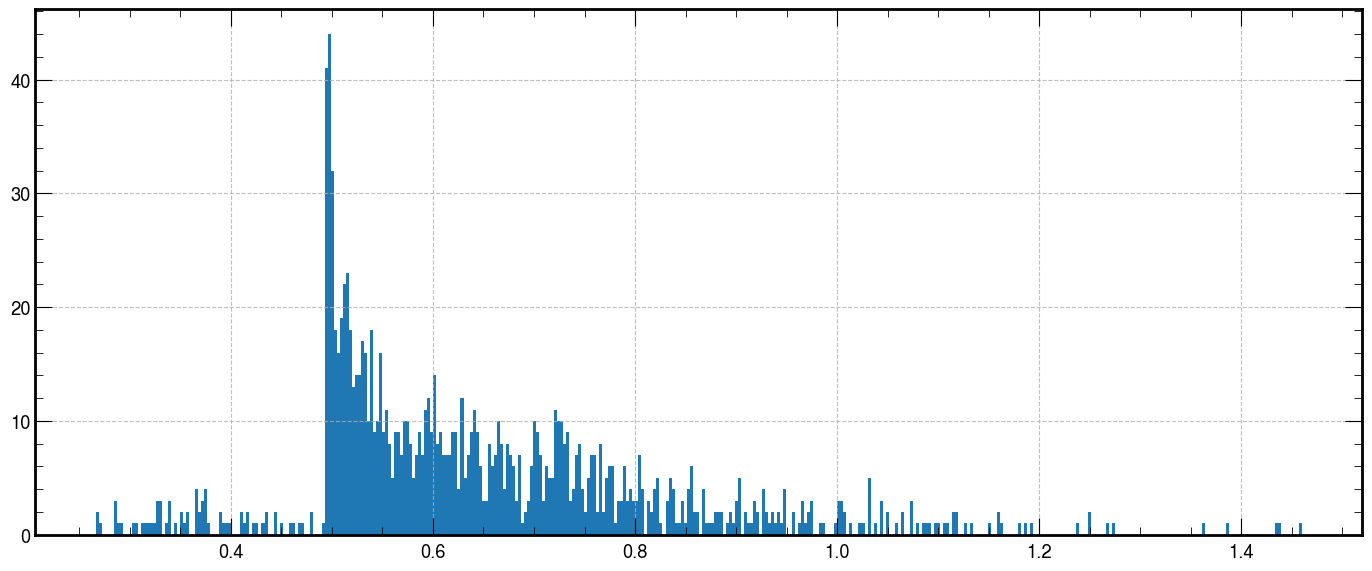

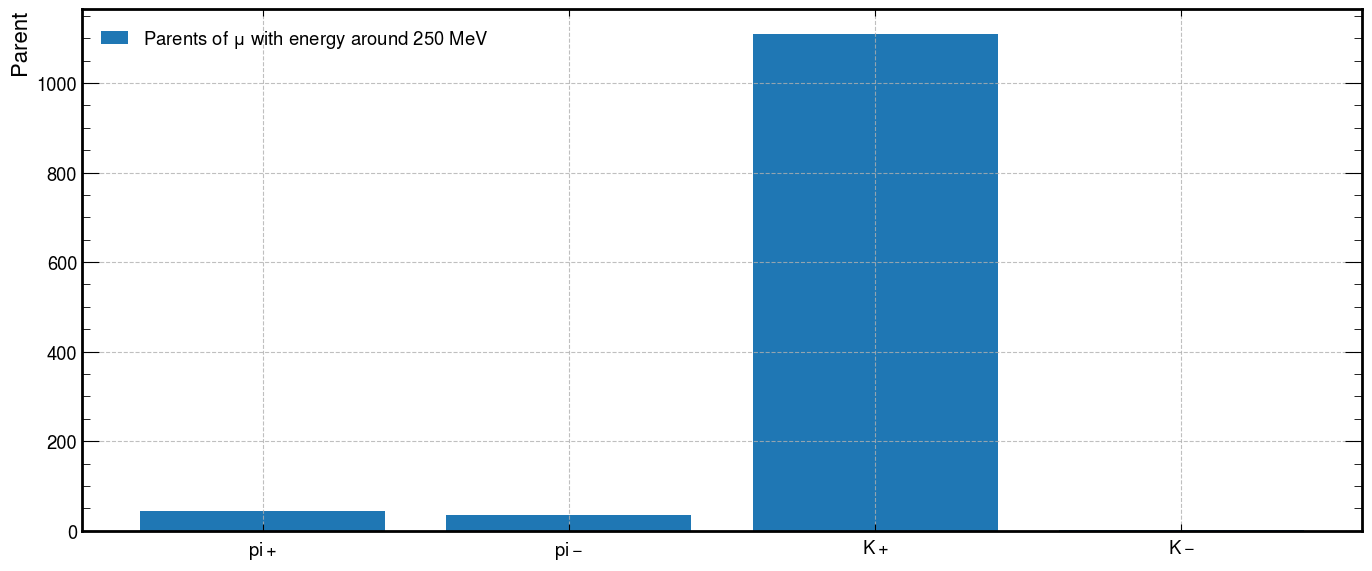

In [241]:
bias_mothers = test.select(
    pl.col(selection_events()),
    pl.col('pdg_geant').apply(lambda x: particle.Particle.from_pdgid(x)),
    pl.col('Eng_geant'),
    pl.col('Mother_geant'),
    pl.col('P_geant')
)
fig = plt.figure()
plt.hist(bias_mothers['Eng_geant'], bins=400);

fig = plt.figure()
bias_mothers = bias_mothers.groupby('pdg_geant').agg(
    entries = pl.col('pdg_geant').count()
)
pdg_names = [fr'${pdg}$' for pdg in bias_mothers['pdg_geant']]
plt.bar(pdg_names ,bias_mothers['entries'],label=fr'Parents of $\mu$ with energy around 250 MeV')
# plt.yscale('log')
plt.tick_params(axis='x',which='minor', bottom=False, top=False)
plt.tick_params(axis='x',which='major', size=5)
plt.ylabel('Parent')
plt.legend()
# test2 = test2.groupby(selection_events(['Mother_geant'])).agg()
# test3 = 0
# for i, g in enumerate(geant):
#     temp = g.join(test2.lazy(), left_on=selection_events(['TrackId_geant']), right_on=selection_events(['Mother_geant']), how='inner')
#     temp = temp.collect()
#     if i == 0:
#         test3 =  temp
#     else:
        
#         test3 = pl.concat([test3,temp], rechunk=False)


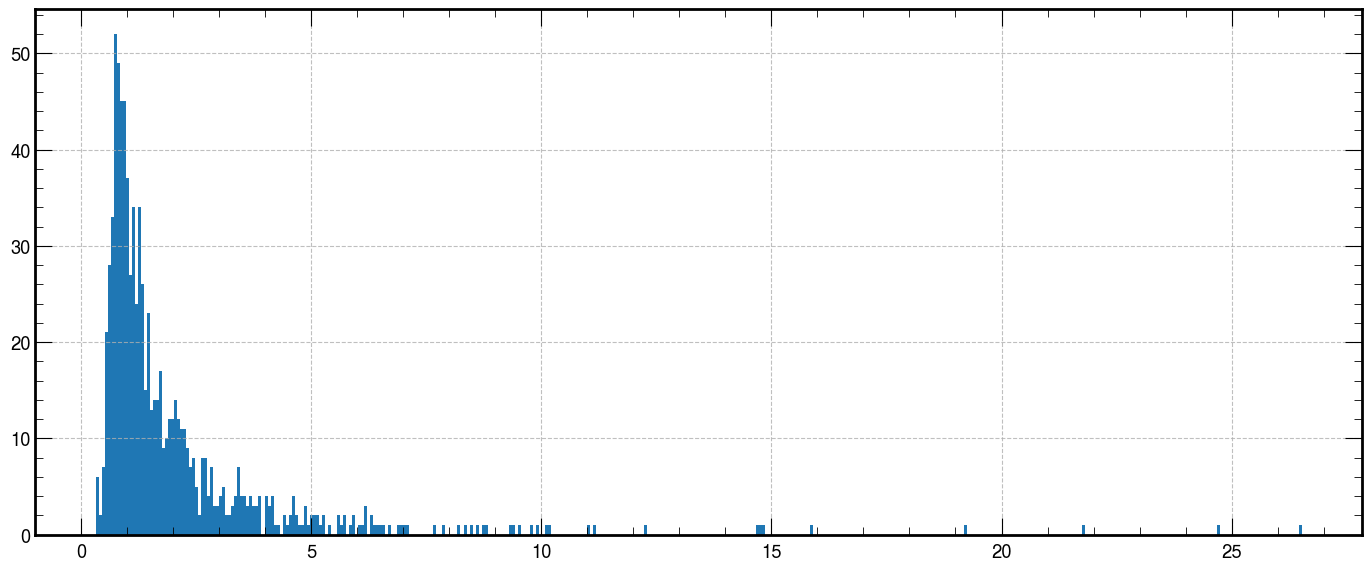

In [ ]:

test4 = test3.select(
    pl.col(selection_events()),
    pl.col('TrackId_geant'),
    pl.col('pdg_geant').apply(lambda x: particle.Particle.from_pdgid(x)),
    pl.col('Eng_geant'),
    pl.col('Mother_geant'),
    pl.col('P_geant')
)
test4
fig = plt.figure()
plt.hist(test4['Eng_geant'], bins=400);

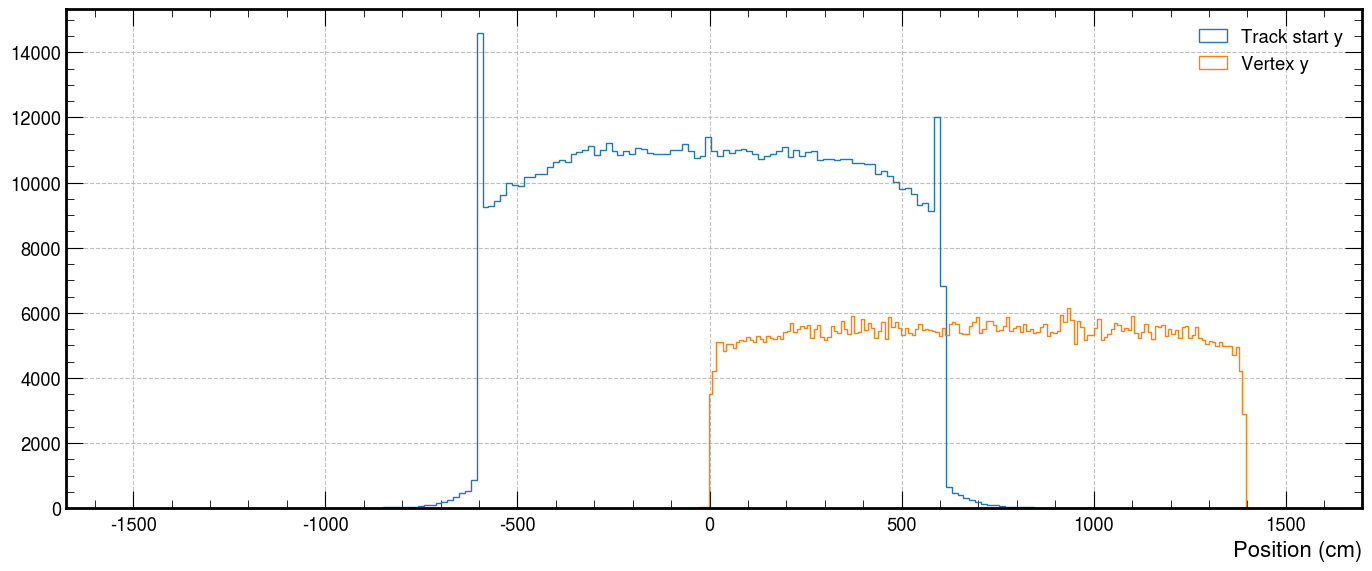

In [12]:

hval, hwidths, _ = plt.hist(df['trkendy_pandoraTrack'], bins=200, label='Track start y', histtype='step')
plt.hist(df['nuvtxz'], bins=200, label='Vertex y', histtype='step')
plt.xlabel('Position (cm)')
# plt.yscale('log')
plt.legend()
# df.filter(
#     pl.col('trklen_pandoraTrack') == pl.max('trklen_pandoraTrack')
# )



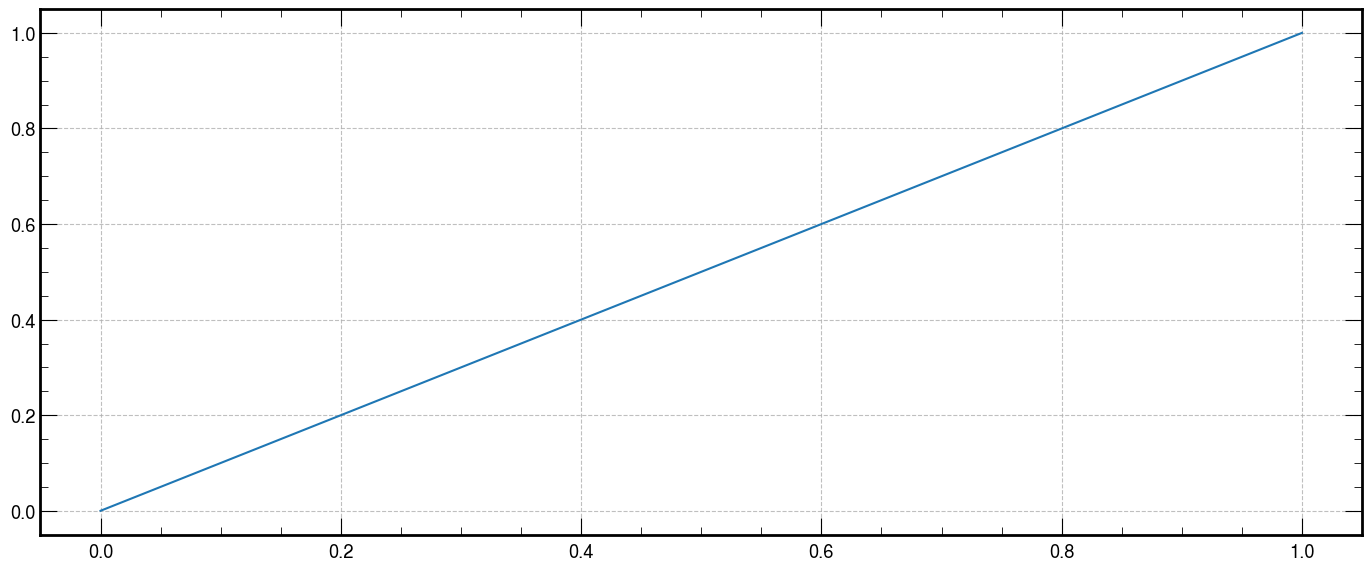

In [256]:
plt.plot([0,1],[0,1], c=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1)
)

In [105]:
biggest_track_possible = np.sqrt((2*363)**2 + (2*608)**2 + (1394)**2)

lgs = merged.filter(
    pl.col("has_valid_pfp")==1
    ).filter(
        (pl.col('trklen_pandoraTrack') > 2*biggest_track_possible)
    ).groupby(selection_events()).agg(['trkPFParticleID_pandoraTrack','has_valid_pfp','pdg_geant']).sort(selection_events())
lgs

subrun,event,trkPFParticleID_pandoraTrack,has_valid_pfp,pdg_geant
i32,i32,list[i16],list[i16],list[i32]
146,10,[0],[1],[22]
227,8,[1],[1],[22]
392,11,[0],[1],[22]
423,9,[0],[1],[22]
437,14,[1],[1],[22]
522,19,[3],[1],[22]
530,17,[2],[1],[22]
561,17,[0],[1],[22]
613,15,[2],[1],[22]
